
# High-level PyTorch or 'What is `torch.nn` *really*'?

Disclaimer: This notebook is an adopted version of [this tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) by Jeremy Howard.

PyTorch provides the elegantly designed modules and classes [torch.nn](https://pytorch.org/docs/stable/nn.html>),
[torch.optim](https://pytorch.org/docs/stable/optim.html), [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset>) and [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) to help you create and train neural networks. In order to fully utilize their power and customize them for your problem, you need to really understand exactly what they're doing. To develop this understanding, we will first train basic neural net on the MNIST data set without using any features from these models; we will initially only use the most basic PyTorch tensor functionality. Then, we will incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or ``DataLoader`` at a time, showing exactly what each piece does, and how it works to make the code either more concise, or more flexible.

**Note:** this tutorial assumes you already have PyTorch installed, and are familiar
with the basics of tensor operations.

### MNIST data setup

We will use the classic [MNIST](http://deeplearning.net/data/mnist/) dataset,
which consists of black-and-white images of hand-drawn digits (between 0 and 9). We download the dataset using [requests](http://docs.python-requests.org/en/master/). We will only import modules when we use them, so you can see exactly what's being used at each point.

Download dataset and store it in `./mnist` dir:

In [3]:
import os
import requests

mnist_path = "./mnist"

os.makedirs(mnist_path, exist_ok=True)

mnist_url = "http://deeplearning.net/data/mnist/"
mnist_filename = "mnist.pkl.gz"
if not os.path.exists(os.path.join(mnist_path, mnist_filename)):
    content = requests.get(mnist_url + mnist_filename).content
    with open(os.path.join(mnist_path, mnist_filename), 'wb') as fout:
        fout.write(content)

This dataset is in numpy array format, and has been stored using pickle,
a python-specific format for serializing data.



In [4]:
import pickle
import gzip

with gzip.open(os.path.join(mnist_path, mnist_filename), "rb") as fin:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(fin, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.



(50000, 784)


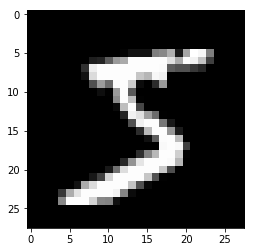

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [77]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape

print("x_train.shape =", x_train.shape)
print("y_train.shape =", y_train.shape)
print("y_train.min(), y_train.max() =", y_train.min(), y_train.max())

/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


x_train.shape = torch.Size([50000, 784])
y_train.shape = torch.Size([50000])
y_train.min(), y_train.max() = tensor(0) tensor(9)


### Neural net from scratch (no torch.nn)

Let's first create a model using nothing but PyTorch tensor operations. We're assuming
you're already familiar with the basics of neural networks.

PyTorch provides methods to create random or zero-filled tensors, which we will
use to create our weights and bias for a simple linear model. These are just regular
tensors, with one very special addition: we tell PyTorch that they require a
gradient. This causes PyTorch to record all of the operations done on the tensor,
so that it can calculate the gradient during back-propagation *automatically*!

For the weights, we set ``requires_grad`` **after** the initialization, since we
don't want that step included in the gradient. (Note that a trailling ``_`` in
PyTorch signifies that the operation is performed in-place.)

**Note:** we are initializing the weights here with [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (by multiplying with $\frac{1}{\sqrt{n}}$).

In [166]:
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()

bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can
use any standard Python function (or callable object) as a model! So
let's just write a plain matrix multiplication and broadcasted addition
to create a simple linear model. We also need an activation function, so
we'll write `LogSoftmax` and use it. `LogSoftmax` is the same as `Softmax`, but **logarithmazied**:

$$
Softmax(z)_i = \sigma (z)_i= \frac{e^{x_i}}{\sum_i{e^{x_i}}}
$$

$$
LogSoftmax(z)_i = \log{\left(Softmax(z)_i\right)}
$$

Final prediction of the classifier is the index returned by `argmax` along the output vector. It's not affected by `log` function, because `log` is a monotonically increasing function and it doesn't change the order relationship of vector's values. So using `LogSoftmax` instead of `Softmax` doesn't spoil anything and visa-versa gives us 2 nice features:
1. To calculate negative log-likelihood loss we'll have to `log` our predictions anyway => it's **faster**, because there is no duplicating of operations
2. Calculating `exp` can be numerically unstable => `log` gives us more **stability**

#### Task 1 (1 point). Basic logisting regression with  `LogSoftmax`.

Expand `LogSoftmax` equation:
$$
LogSoftmax(z)_i = \log{\left(Softmax(z)_i\right)} = x_i - \log{(\sum_i{e^{x_i})}}
$$

Implement `LogSoftmax` (use expanded version, that you got above):

In [167]:
def log_softmax(x):
    result = x - torch.log(torch.sum(torch.exp(x), dim=1)).reshape(-1, 1)
    return result

And now our model is defined like this:

In [168]:
def model(xb):
    return log_softmax(xb.mm(weights) + bias)

We will call our function on one batch of data (in this case, 64 images). This is
one *forward pass*. Note that our predictions won't be any better than random at this stage, since we start with random weights.

In [169]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.8266, -2.6766, -2.0655, -2.4084, -2.0344, -2.7267, -2.5688, -2.2239,
        -2.0369, -1.9391], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the ``preds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do backprop.

As a loss function we'll use **negative log-likelihood loss** (or log-loss):
$$
nll(y^{pred}, y) = -\frac{1}{N} \sum_{i=0}^{N-1} \sum_{c=0}^{C-1} y_{ic}\log{y_{ic}^{pred}}
$$

where $N$ - batch size, $C$ - number of classes, $y_i$ - ground truth one-hot vector.

Let's implement **nll**! But, remember 2 things:
1. (!) Predictions of our model are already logarithmazied
2. There is only one non-zero element in $y_i$, so `nll` can be implemented very efficiently

In [170]:
def nll(input, target):
    result = - torch.mean(input[range(input.shape[0]), target])
    return result

loss_func = nll

Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.

In [171]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3478, grad_fn=<NegBackward>)


Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.

In [172]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    result = torch.mean(torch.tensor(preds == yb, dtype=torch.float32))
    return result

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.

In [173]:
print(accuracy(preds, yb))

tensor(0.0781)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- use the model to make predictions
- calculate the loss
- ``loss.backward()`` updates the gradients of the model, in this case, ``weights``
  and ``bias``.

We now use these gradients to update the weights and bias.  We do this
within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations
[here](https://pytorch.org/docs/stable/notes/autograd.html>).

**Note:** in the previous seminar we hacked the internals of `torch.tensor` not to record operations in PyTorch's Autograd (we used  `tensor.data` attribute). Above is presented a cleaner way to make gradient step.

We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is already stored, rather than replacing them).

In [180]:
%%time
lr = 0.1  # learning rate
epochs = 20  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

CPU times: user 9.48 s, sys: 678 ms, total: 10.2 s
Wall time: 8.96 s


That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



In [181]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1343, grad_fn=<NegBackward>) tensor(1.)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Wow! Accuracy is close to 1.0. Is it overfitting?

### Using torch.nn.functional

We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of PyTorch's ``nn`` classes to make it more concise
and flexible. At each step from here, we should be making our code one or more
of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``torch.nn.functional``
(which is generally imported into the namespace ``F`` by convention). This module
contains all the functions in the ``torch.nn`` library (whereas other parts of the
library contain classes). As well as a wide range of loss and activation
functions, you'll also find here some convenient functions for creating neural
nets, such as pooling functions. (There are also functions for doing convolutions,
linear layers, etc, but as we'll see, these are usually better handled using
other parts of the library.)

**Note:** if you're using negative log likelihood loss and log softmax activation,
then Pytorch provides a single function ``F.cross_entropy`` that combines
the two. So we can even remove the activation function from our model.

In [182]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb.mm(weights) + bias

Note that we no longer call ``log_softmax`` in the ``model`` function. Let's
confirm that our loss and accuracy are the same as before:



In [183]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1343, grad_fn=<NllLossBackward>) tensor(1.)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Here we got the same value for loss and accuracy just as above.

Refactor using nn.Module
-----------------------------
Next up, we'll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more
concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``)
which we will be using.

**Note:**``nn.Module`` (uppercase M) is a PyTorch specific concept, and is a class we'll be using a lot. ``nn.Module`` is not to be confused with the Python concept of a (lowercase ``m``) [module](https://docs.python.org/3/tutorial/modules.html>), which is a file of Python code that can be imported.

In [184]:
from torch import nn

class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()  # init super class
        
        self.weights = nn.Parameter(torch.randn(784, 10) / np.sqrt(784))  # nn.Parameter has requires_grad=True
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb.mm(self.weights) + self.bias

Since we're now using an object instead of just using a function, we
first have to instantiate our model:



In [186]:
model = MnistLogistic()

Now we can calculate the loss in the same way as before. Note that
``nn.Module`` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes Pytorch will call our ``forward``
method automatically.



In [187]:
print(loss_func(model(xb), yb))

tensor(2.3309, grad_fn=<NllLossBackward>)


Previously for our training loop we had to update the values for each parameter
by name, and manually zero out the grads for each parameter separately, like this:
```python
  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()
```

Now we can take advantage of model.parameters() and model.zero_grad() (which
are both defined by PyTorch for ``nn.Module``) to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model:
```python
  with torch.no_grad():
      for p in model.parameters():
          p -= p.grad * lr
      model.zero_grad()
```

#### Task 2 (1 point). Implement train-loop in nn.Module style (as shown above).

In [192]:
from tqdm import tqdm

In [193]:
%%time
lr = 0.1  # learning rate
epochs = 20  # how many epochs to train for

for epoch in tqdm(range(epochs)):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
            model.zero_grad()

100%|██████████| 20/20 [00:07<00:00,  2.73it/s]

CPU times: user 8.19 s, sys: 723 ms, total: 8.91 s
Wall time: 7.9 s


Let's double-check that our loss has gone down:



In [194]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1317, grad_fn=<NllLossBackward>) tensor(1.)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


### Refactor using nn.Linear

We continue to refactor our code. Instead of manually defining and initializing ``self.weights`` and ``self.bias``, and calculating ``xb.mm(self.weights) + self.bias``, we will instead use the Pytorch class [nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers) for a linear layer, which does all that for us. Pytorch has many types of predefined layers that can greatly simplify our code, and often makes it faster too.

In [195]:
class MnistLogistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:



In [196]:
model = MnistLogistic()
print(loss_func(model(xb), yb))

tensor(2.3557, grad_fn=<NllLossBackward>)


In [197]:
lr = 0.1
epochs = 40

for epoch in tqdm(range(epochs)):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
            model.zero_grad()

print(loss_func(model(xb), yb))

100%|██████████| 40/40 [00:13<00:00,  3.29it/s]

tensor(0.1333, grad_fn=<NllLossBackward>)


In [198]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1333, grad_fn=<NllLossBackward>) tensor(1.)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


### Refactor using optim

Pytorch also has a package with various optimization algorithms, ``torch.optim``.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
```python
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()
```

and instead use just:
```
  opt.step()
  opt.zero_grad()
```
(``optim.zero_grad()`` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.)



In [199]:
from torch import optim

#### Task 3 (1 point). Optimize model using [optim.SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [205]:
lr = 0.1
epochs = 20

model = MnistLogistic()
opt = optim.Adam(model.parameters(), lr)
print(loss_func(model(xb), yb))

for epoch in tqdm(range(epochs)):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

  0%|          | 0/20 [00:00<?, ?it/s]

tensor(2.3578, grad_fn=<NllLossBackward>)


100%|██████████| 20/20 [00:12<00:00,  1.60it/s]

tensor(0.0106, grad_fn=<NllLossBackward>)


In [206]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0106, grad_fn=<NllLossBackward>) tensor(1.)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


### Refactor using Dataset


PyTorch has an abstract Dataset class.  A Dataset can be anything that has a ``__len__`` function (called by Python's standard ``len`` function) and a ``__getitem__`` function as a way of indexing into it. [This tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) walks through a nice example of creating a custom ``FacialLandmarkDataset`` class as a subclass of ``Dataset``.

PyTorch's [TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>) is a Dataset wrapping tensors. By defining a length and way of indexing, this also gives us a way to iterate, index, and slice along the first dimension of a tensor. This will make it easier to access both the independent and dependent variables in the same line as we train.

In [207]:
from torch.utils.data import TensorDataset

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.



In [208]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
::
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]


Now, we can do these two steps together:
::
    xb,yb = train_ds[i*bs : i*bs+bs]




In [209]:
lr = 0.5
epochs = 2

model = MnistLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


### Refactor using DataLoader

Pytorch's ``DataLoader`` is responsible for managing batches. You can create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``, the DataLoader gives us each minibatch automatically.

In [210]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this:
```python
      for i in range((n - 1) // bs + 1):
          xb, yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)
```       
 

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
```python
      for xb, yb in train_dl:
          pred = model(xb)
```

In [212]:
lr = 0.1
epochs = 30

model = MnistLogistic()
opt = optim.SGD(model.parameters(), lr=lr)

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.1478, grad_fn=<NllLossBackward>)


In [213]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1478, grad_fn=<NllLossBackward>) tensor(1.)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effecive models in practice.

### Add validation

In section 1, we were just trying to get a reasonable training loop set up for use on our training data.  In reality, you **always** should also have a validation set, in order to identify if you are overfitting.

Shuffling the training data is [important](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks>) to prevent correlation between batches and overfitting. On the other hand, the validation loss will be identical whether we shuffle the validation set or not. Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as that for the training set. This is because the validation set does not need backpropagation and thus takes less memory (it doesn't need to store the gradients). We take advantage of this to use a larger batch size and compute the loss more quickly.

#### Task 4 (1 point). Setup validation using recommendations given above.

In [214]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)


valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [218]:
lr = 0.1
epochs = 30

model = MnistLogistic()
opt = optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(epochs)):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

  3%|▎         | 1/30 [00:01<00:29,  1.02s/it]

0 tensor(1.4000)


  7%|▋         | 2/30 [00:02<00:29,  1.04s/it]

1 tensor(1.4591)


 10%|█         | 3/30 [00:03<00:29,  1.09s/it]

2 tensor(1.7718)


 13%|█▎        | 4/30 [00:04<00:29,  1.15s/it]

3 tensor(1.6215)


 17%|█▋        | 5/30 [00:05<00:28,  1.14s/it]

4 tensor(1.7969)


 20%|██        | 6/30 [00:06<00:27,  1.13s/it]

5 tensor(1.6770)


 23%|██▎       | 7/30 [00:07<00:25,  1.13s/it]

6 tensor(1.9978)


 27%|██▋       | 8/30 [00:09<00:24,  1.13s/it]

7 tensor(1.6004)


 30%|███       | 9/30 [00:10<00:23,  1.12s/it]

8 tensor(1.8492)


 33%|███▎      | 10/30 [00:11<00:22,  1.12s/it]

9 tensor(1.6956)


 37%|███▋      | 11/30 [00:12<00:22,  1.18s/it]

10 tensor(1.8647)


 40%|████      | 12/30 [00:13<00:20,  1.16s/it]

11 tensor(1.5448)


 43%|████▎     | 13/30 [00:14<00:19,  1.15s/it]

12 tensor(1.8279)


 47%|████▋     | 14/30 [00:15<00:18,  1.14s/it]

13 tensor(1.8987)


 50%|█████     | 15/30 [00:17<00:16,  1.13s/it]

14 tensor(1.8898)


 53%|█████▎    | 16/30 [00:18<00:16,  1.19s/it]

15 tensor(1.7891)


 57%|█████▋    | 17/30 [00:19<00:15,  1.20s/it]

16 tensor(1.8698)


 60%|██████    | 18/30 [00:20<00:14,  1.17s/it]

17 tensor(1.8476)


 63%|██████▎   | 19/30 [00:22<00:13,  1.22s/it]

18 tensor(2.0975)


 67%|██████▋   | 20/30 [00:23<00:12,  1.29s/it]

19 tensor(2.1339)


 70%|███████   | 21/30 [00:24<00:11,  1.29s/it]

20 tensor(1.7954)


 73%|███████▎  | 22/30 [00:26<00:10,  1.35s/it]

21 tensor(2.0596)


 77%|███████▋  | 23/30 [00:27<00:09,  1.29s/it]

22 tensor(1.8902)


 80%|████████  | 24/30 [00:28<00:07,  1.26s/it]

23 tensor(1.8810)


 83%|████████▎ | 25/30 [00:29<00:06,  1.27s/it]

24 tensor(1.9765)


 87%|████████▋ | 26/30 [00:31<00:04,  1.24s/it]

25 tensor(1.9827)


 90%|█████████ | 27/30 [00:32<00:03,  1.20s/it]

26 tensor(1.8636)


 93%|█████████▎| 28/30 [00:33<00:02,  1.18s/it]

27 tensor(1.9770)


 97%|█████████▋| 29/30 [00:34<00:01,  1.22s/it]

28 tensor(1.9258)


100%|██████████| 30/30 [00:35<00:00,  1.23s/it]

29 tensor(1.8586)


In [219]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.1229, grad_fn=<NllLossBackward>) tensor(0.9375)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


### nn.Sequential

``torch.nn`` has another handy class we can use to simply our code:
[Sequential](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>).
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

Let's create 2-layer (OMG) neural network with `ReLU` nonlinearity:

In [226]:
model = nn.Sequential(
    nn.Linear(784, 64),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(64, 10)
)

In [227]:
lr = 0.01
epochs = 20

opt = optim.Adam(model.parameters(), lr=lr)

for epoch in tqdm(range(epochs)):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

  5%|▌         | 1/20 [00:01<00:28,  1.50s/it]

0 tensor(0.2102)


 10%|█         | 2/20 [00:03<00:27,  1.55s/it]

1 tensor(0.1794)


 15%|█▌        | 3/20 [00:04<00:27,  1.59s/it]

2 tensor(0.1750)


 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

3 tensor(0.1799)


 25%|██▌       | 5/20 [00:08<00:25,  1.68s/it]

4 tensor(0.1740)


 30%|███       | 6/20 [00:10<00:23,  1.70s/it]

5 tensor(0.1752)


 35%|███▌      | 7/20 [00:11<00:22,  1.73s/it]

6 tensor(0.1650)


 40%|████      | 8/20 [00:13<00:21,  1.77s/it]

7 tensor(0.1628)


 45%|████▌     | 9/20 [00:15<00:19,  1.82s/it]

8 tensor(0.1676)


 50%|█████     | 10/20 [00:17<00:18,  1.86s/it]

9 tensor(0.1629)


 55%|█████▌    | 11/20 [00:19<00:16,  1.87s/it]

10 tensor(0.1733)


 60%|██████    | 12/20 [00:21<00:15,  1.95s/it]

11 tensor(0.1784)


 65%|██████▌   | 13/20 [00:23<00:13,  1.99s/it]

12 tensor(0.1724)


 70%|███████   | 14/20 [00:25<00:12,  2.02s/it]

13 tensor(0.1658)


 75%|███████▌  | 15/20 [00:27<00:09,  1.99s/it]

14 tensor(0.1754)


 80%|████████  | 16/20 [00:29<00:07,  1.96s/it]

15 tensor(0.1716)


 85%|████████▌ | 17/20 [00:31<00:05,  1.94s/it]

16 tensor(0.1785)


 90%|█████████ | 18/20 [00:33<00:03,  1.92s/it]

17 tensor(0.1657)


 95%|█████████▌| 19/20 [00:35<00:01,  1.97s/it]

18 tensor(0.1662)


100%|██████████| 20/20 [00:37<00:00,  2.02s/it]

19 tensor(0.1729)


In [228]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.2619, grad_fn=<NllLossBackward>) tensor(0.9375)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [228]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.2619, grad_fn=<NllLossBackward>) tensor(0.9375)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [235]:
with torch.no_grad():
    valid_acc = sum(accuracy(model(xb), yb) for xb, yb in valid_dl)

print(epoch, valid_acc / len(valid_dl))

1 tensor(0.9149)


/Users/maxim/code/git/fintech/learning-deep-learning/dl_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Using your GPU
---------------

If you're lucky enough to have access to a CUDA-capable GPU (you can
rent one for about about $0.50/hour from most cloud providers) you can
use it to speed up your code. First check that your GPU is working in
Pytorch:



In [229]:
print(torch.cuda.is_available())

False


And then create a device object for it:



In [230]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [231]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

Finally, we can move our model to the GPU.



In [232]:
lr = 0.5
epochs = 2

model = MnistLogistic()
model.to(device)

opt = optim.SGD(model.parameters(), lr=lr)

You should find it runs faster now:



In [233]:
for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb.to(device)), yb.to(device)) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3289)
1 tensor(0.3000)


Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth, but we'll learn it later.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.